## Gradient Boost using H2O

In [ ]:
import h2o
import pandas as pd
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
from sqlalchemy import create_engine
import re
from io import StringIO
import math

In [ ]:
# h2o.cluster().shutdown()

In [ ]:
path_file = r'assets\lin_model_class\pages.stern.nyu.edu_~wgreene_Text_Edition7_TableF5-1.txt'

with open(path_file) as table_5:
    data = table_5.read()
    data_info = re.search(
        r'(?:[/*].+?)(?=doc)(doc.+?(?=[*/]))\*\/\n(.+)', 
        data, re.DOTALL).group(1)
    data_cleaned = re.search(
        r'(?:[/*].+?)(?=doc)(doc.+?(?=[*/]))\*\/\n(.+)', 
        data, re.DOTALL).group(2)
    data_formatted = re.sub(r'[ ]+', r',', data_cleaned)
    data_consol = pd.read_csv(StringIO(data_formatted), sep=',')

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 22.0.1+8-16, mixed mode, sharing)
  Starting server from C:\Users\dante\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\dante\AppData\Local\Temp\tmpegdbf2yk
  JVM stdout: C:\Users\dante\AppData\Local\Temp\tmpegdbf2yk\h2o_dante_started_from_python.out
  JVM stderr: C:\Users\dante\AppData\Local\Temp\tmpegdbf2yk\h2o_dante_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Lima
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.2
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_dante_2mhra8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.909 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [ ]:
# Convert to H2O frame
data_frame = h2o.H2OFrame(data_consol)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
print(data_info)

doc LFP  "A dummy variable = 1 if woman worked in 1975, else 0";
doc WHRS "Wife's hours of work in 1975";
doc KL6  "Number of children less than 6 years old in household";
doc K618 "Number of children between ages 6 and 18 in household";
doc WA   "Wife's age";
doc WE   "Wife's educational attainment, in years";
doc WW   "Wife's average hourly earnings, in 1975 dollars";
doc RPWG "Wife's wage reported at the time of the 1976 interview\
 (not the same as the 1975 estimated wage).\
 To use the subsample with this wage, one needs to select 1975\
 workers with LFP=1, then select only those women with non-zero RPWG.\
 Only 325 women work in 1975 and have a non-zero RPWG in 1976.";
doc HHRS "Husband's hours worked in 1975";
doc HA   "Husband's age";
doc HE   "Husband's educational attainment, in years";
doc HW   "Husband's wage, in 1975 dollars";
doc FAMINC "Family income, in 1975 dollars.\
 This variable is used to construct the property income variable.";
doc MTR  "This is the marginal tax 

In [ ]:
response = 'LFP'
numerical_feats = ["WA", "WE", "HHRS", "HA", "HE", "HW", "WMED", "WFED", "UN", "AX"]
categorical_feats = ["KL6", "K618", "CIT"]

In [ ]:
data_frame[response] = data_frame[response].asfactor()
data_frame[numerical_feats] = data_frame[numerical_feats].asnumeric()
data_frame[categorical_feats] = data_frame[categorical_feats].asfactor()

In [ ]:
train, valid, test = data_frame.split_frame(
    ratios = [0.6, 0.2],
    seed = 1234
)

In [ ]:
gbm_default = H2OGradientBoostingEstimator()
gbm_default.train(x = numerical_feats + categorical_feats, 
                  y=response, 
                  training_frame = train, 
                  validation_frame = valid)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1716050170489_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          13263                  5            5            5             8             23            16.48

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.05511890024691459
RMSE: 0.23477414731378451
LogLoss: 0.23116843900010717
Mean Per-Class Error: 0.03315708305794228
AUC: 0.9956237857758016
AUCPR: 0.9969284660800918
Gini: 0.9912475715516031

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47541314711811655
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      176  11   0.0588   (11.0/187.0)
1      2    265  0.0075   (2.0/267.0)
Total  178  276  0.0286   (13.0/454.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475413     0.976059  238
max f2                       0.475413     0.985863  238
max f0point5                 0.564306     0.980168  225
max accuracy                 0.550484     0.971366  227
max precision                0.979918     1         0
max recall                   0.336399     1         272
max specificity              0.979918     1         0
max absolute_mcc             0.475413     0.941267  238
max min_per_class_accuracy   0.550484     0.970037  227
max mean_per_class_accuracy  0.550484     0.97165   227
max tns                      0.979918     187       0
max fns                      0.979918     266       0
max fps                      0.0334024    187       399
max tps                      0.336399     267       272
max tnr                      0.979918     1         0
max fnr                      0.979918     0.996255  0
max fpr                      0.0334024    1         399
max tpr                      0.336399     1         272

Gains/Lift Table: Avg response rate: 58.81 %, avg score: 58.78 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0110132                   0.966809           1.70037   1.70037            1                0.97258    1                           0.97258             0.0187266       0.0187266                  70.0375   70.0375            0.0187266
2        0.0220264                   0.963672           1.70037   1.70037            1                0.965437   1                           0.969009            0.0187266       0.0374532                  70.0375   70.0375            0.0374532
3        0.030837                    0.958025           1.70037   1.70037            1                0.96053    1                           0.966586            0.0149813       0.0524345                  70.0375   70.0375            0.0524345
4        0.0418502                   0.954412           1.70037   1.70037            1                0.956141   1                           0.963838            0.0187266       0.071161                   70.0375   70.0375            0.071161
5        0.0506608                   0.950854           1.70037   1.70037            1                0.952701   1                           0.961901            0

### Explaining model with Shap Values

In [ ]:
import matplotlib.pyplot as plt


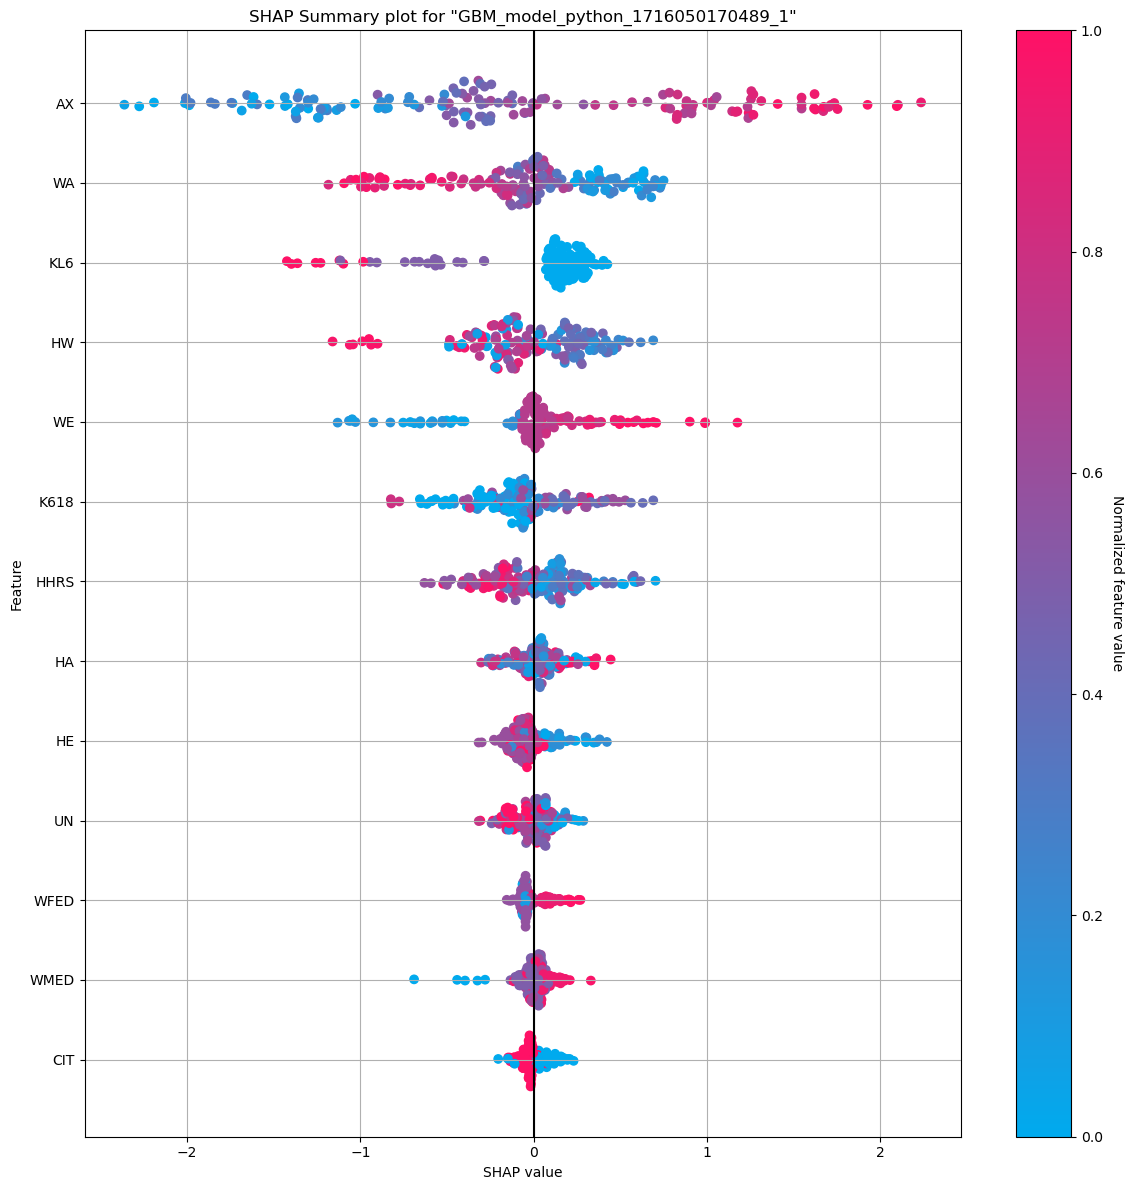

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_model_python_1716050170489_1

,0,1,Error,Rate
0,46.0,28.0,0.3784,(28.0/74.0)
1,13.0,66.0,0.1646,(13.0/79.0)
Total,59.0,94.0,0.268,(41.0/153.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

c:\Users\dante\anaconda3\Lib\site-packages\h2o\explanation\_explain.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

c:\Users\dante\anaconda3\Lib\site-packages\h2o\explanation\_explain.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

c:\Users\dante\anaconda3\Lib\site-packages\h2o\explanation\_explain.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

c:\Users\dante\anaconda3\Lib\site-packages\h2o\explanation\_explain.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_model_python_1716050170489_1

,0,1,Error,Rate
0,46.0,28.0,0.3784,(28.0/74.0)
1,13.0,66.0,0.1646,(13.0/79.0)
Total,59.0,94.0,0.268,(41.0/153.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

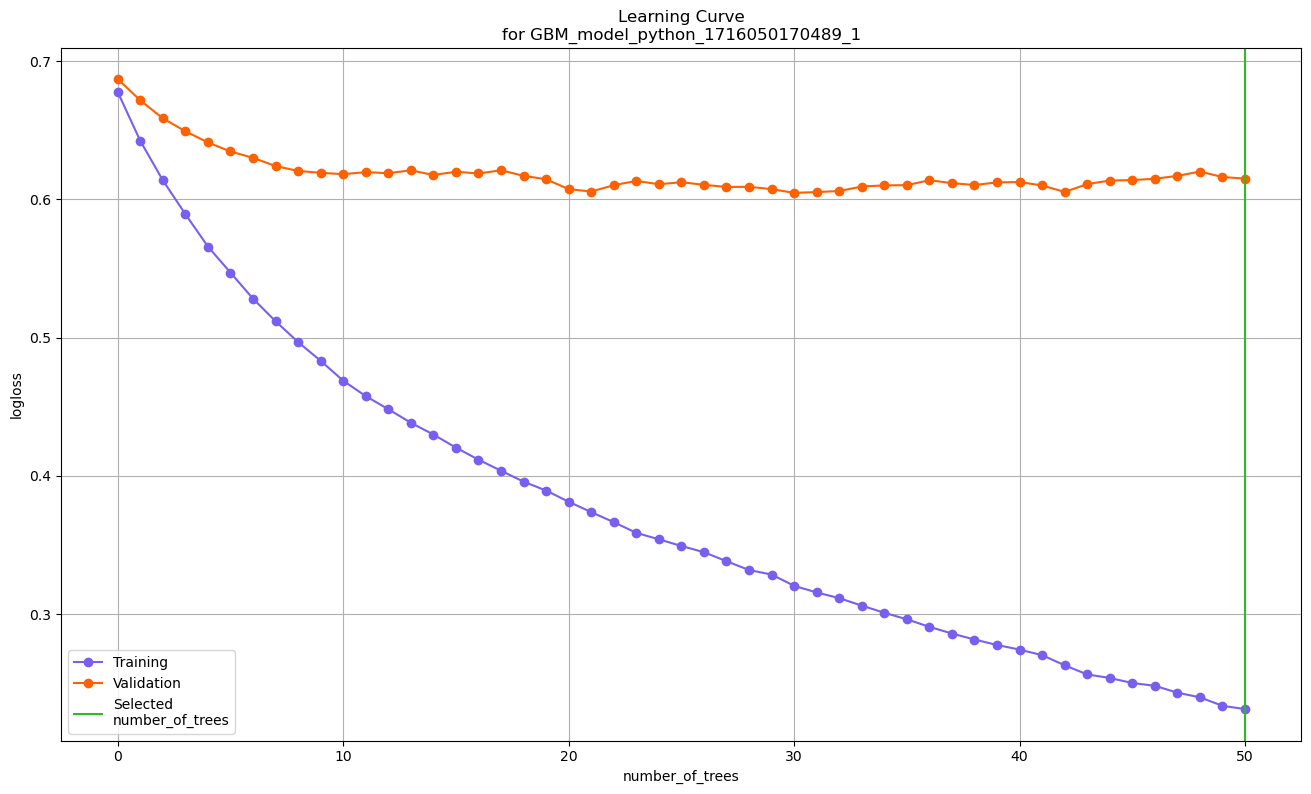

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

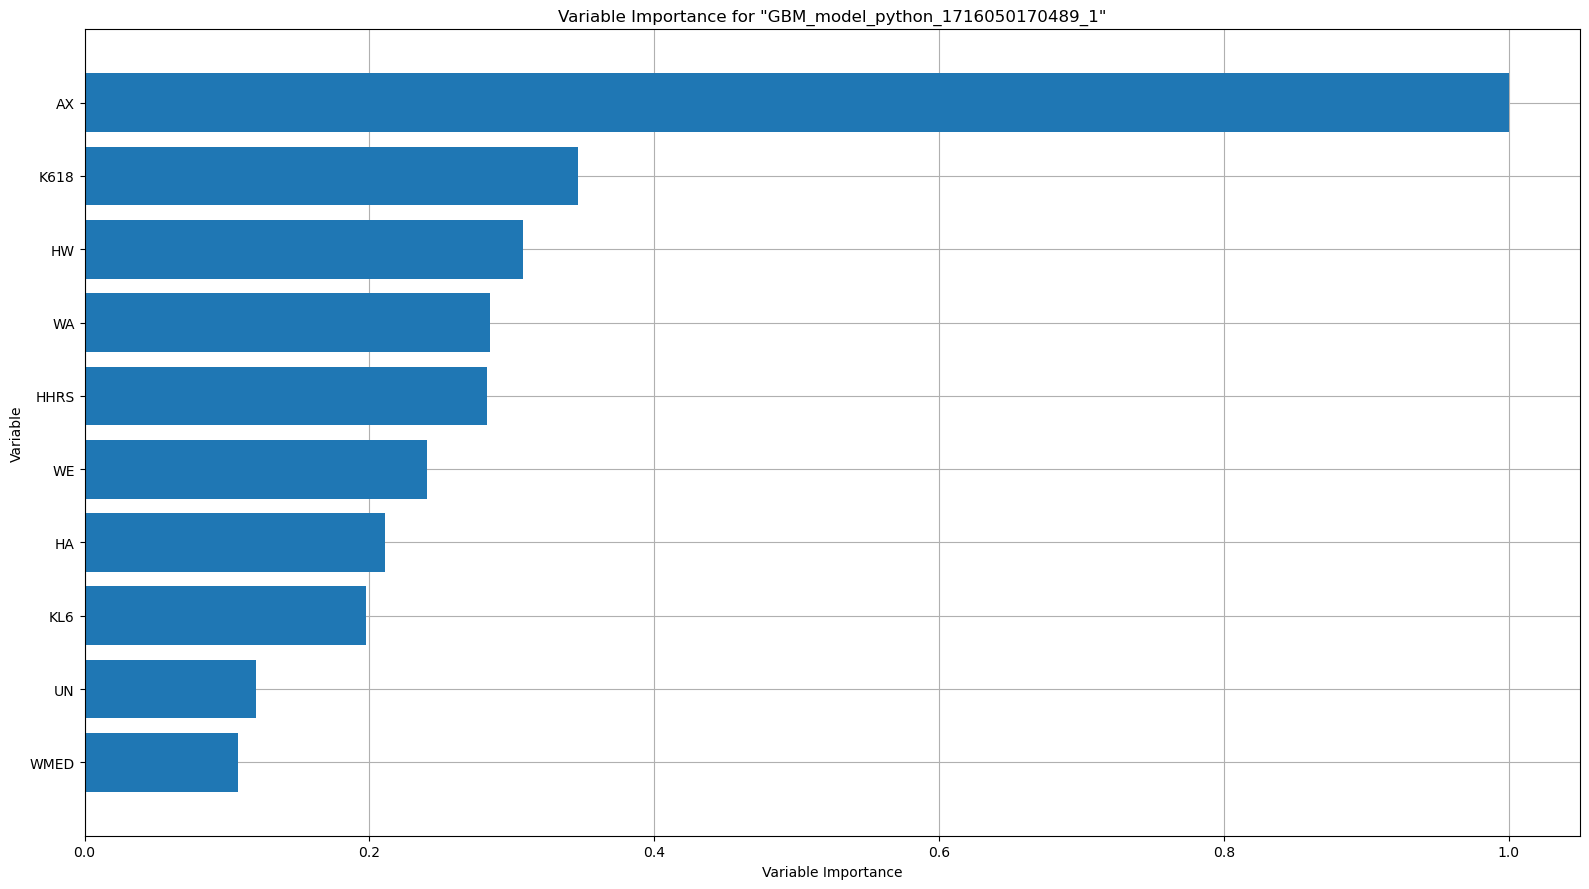

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

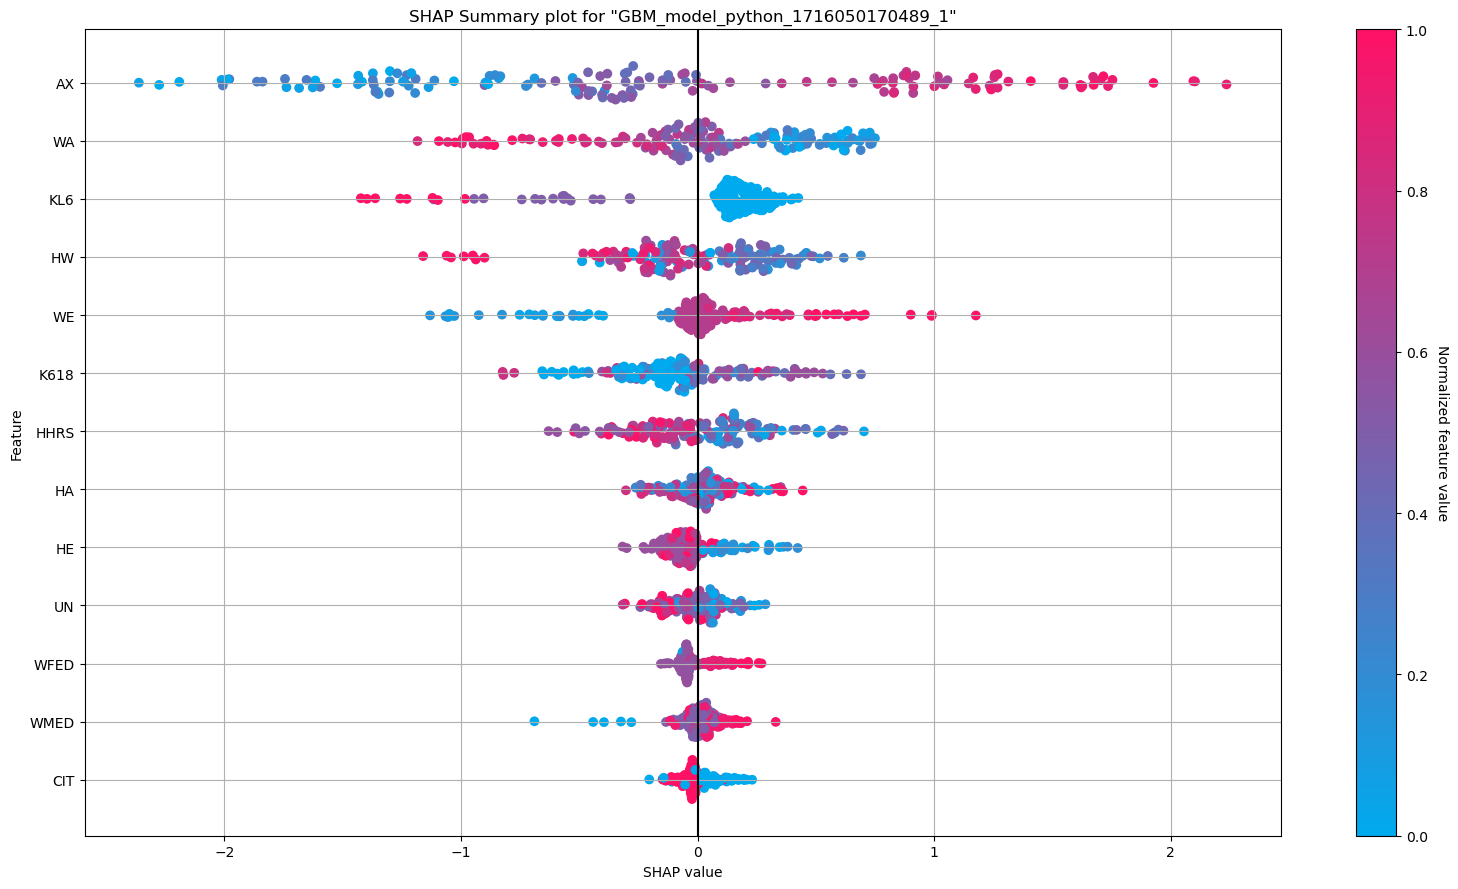

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

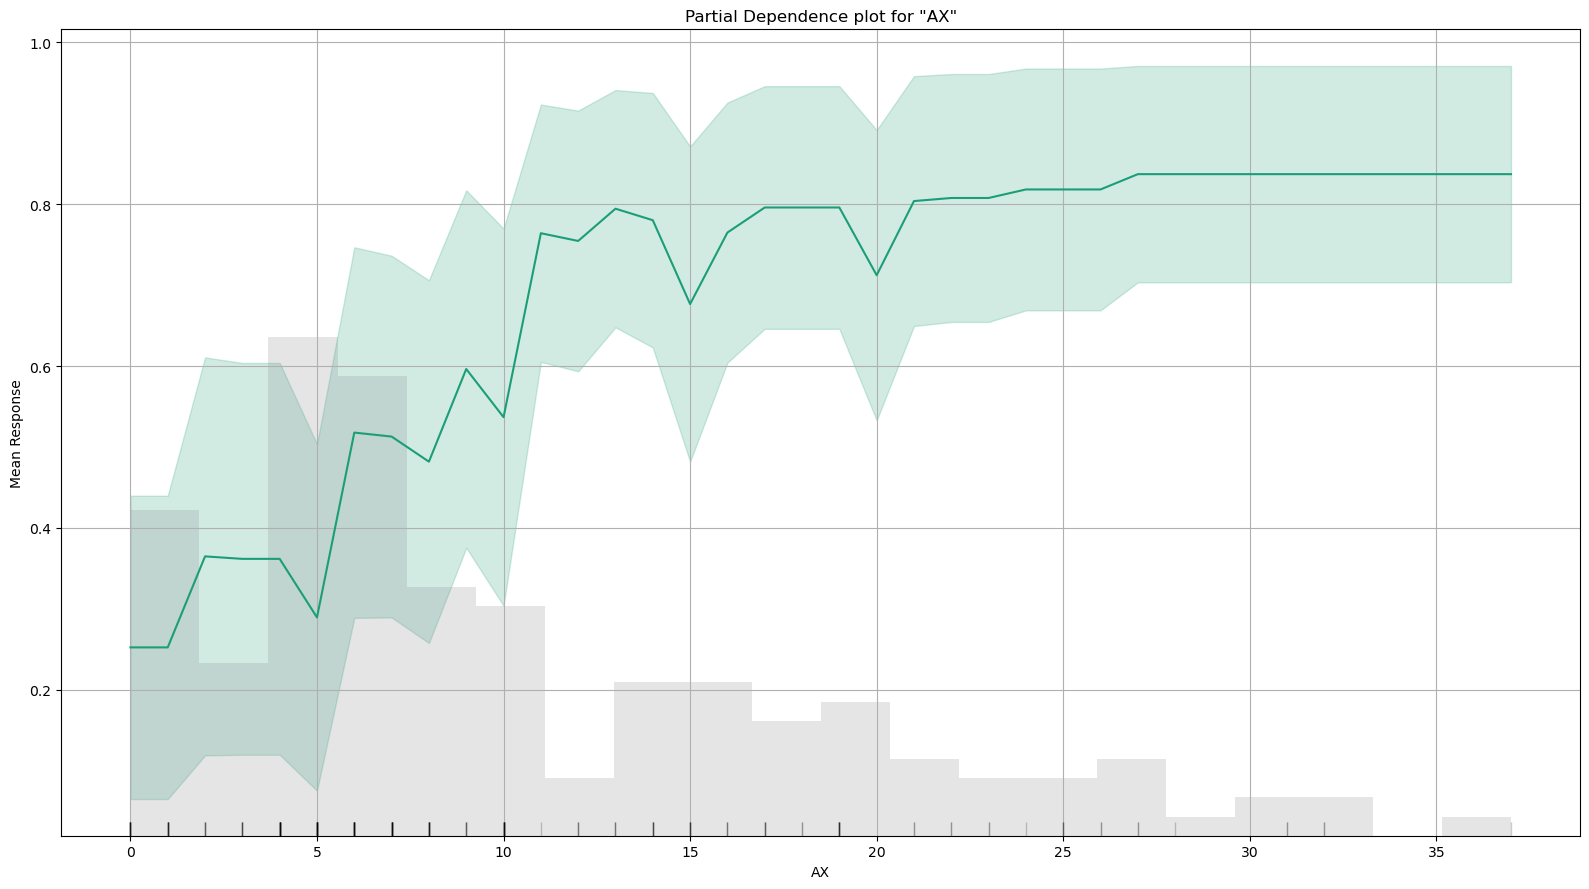

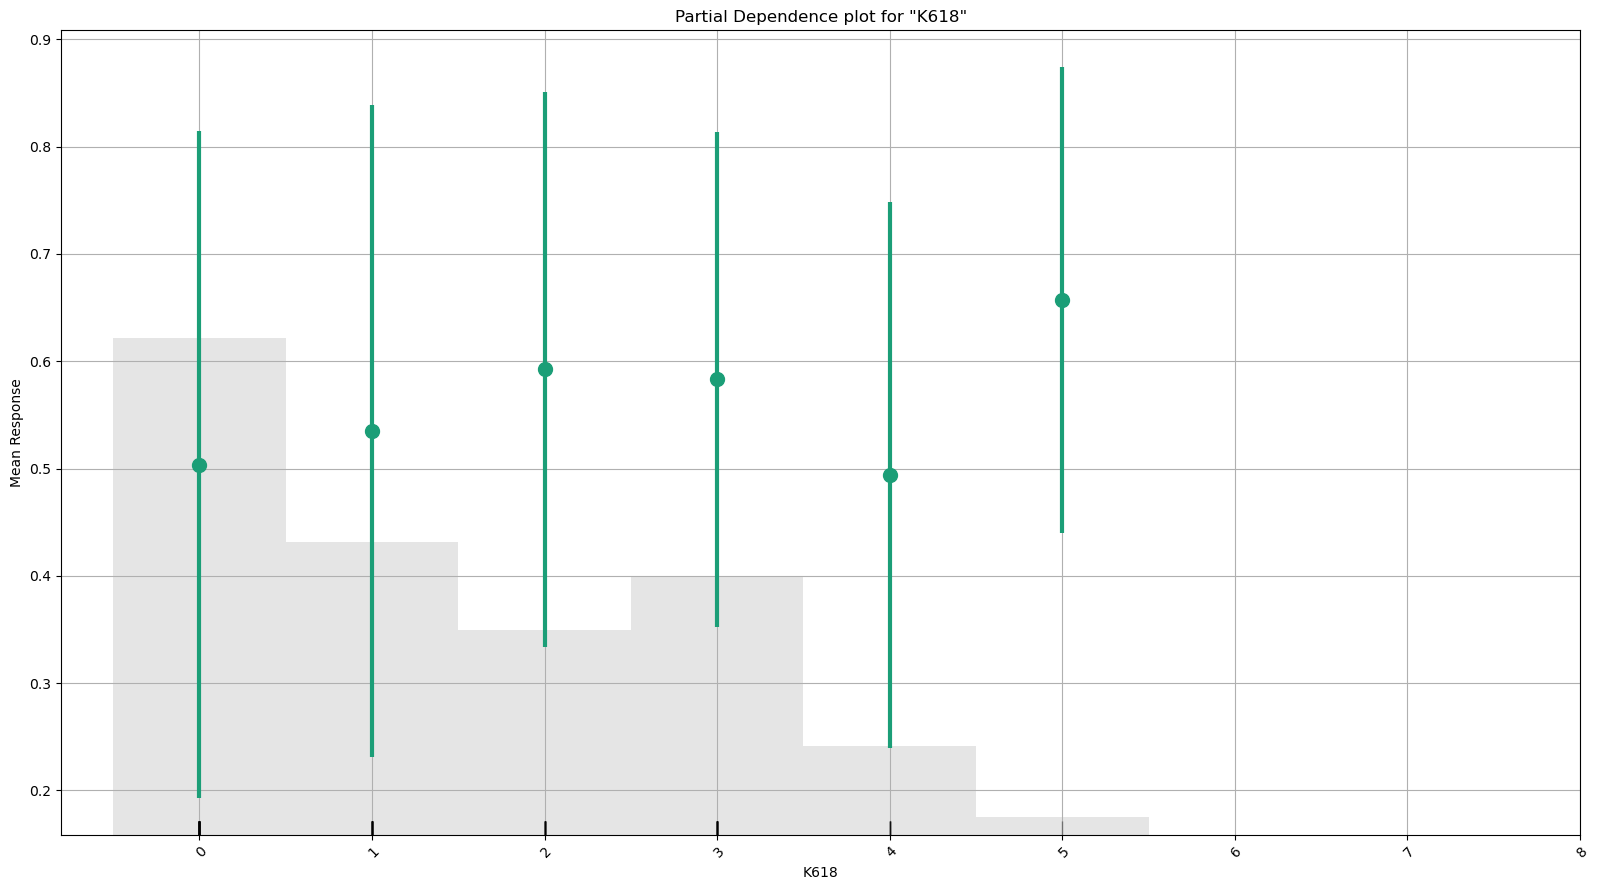

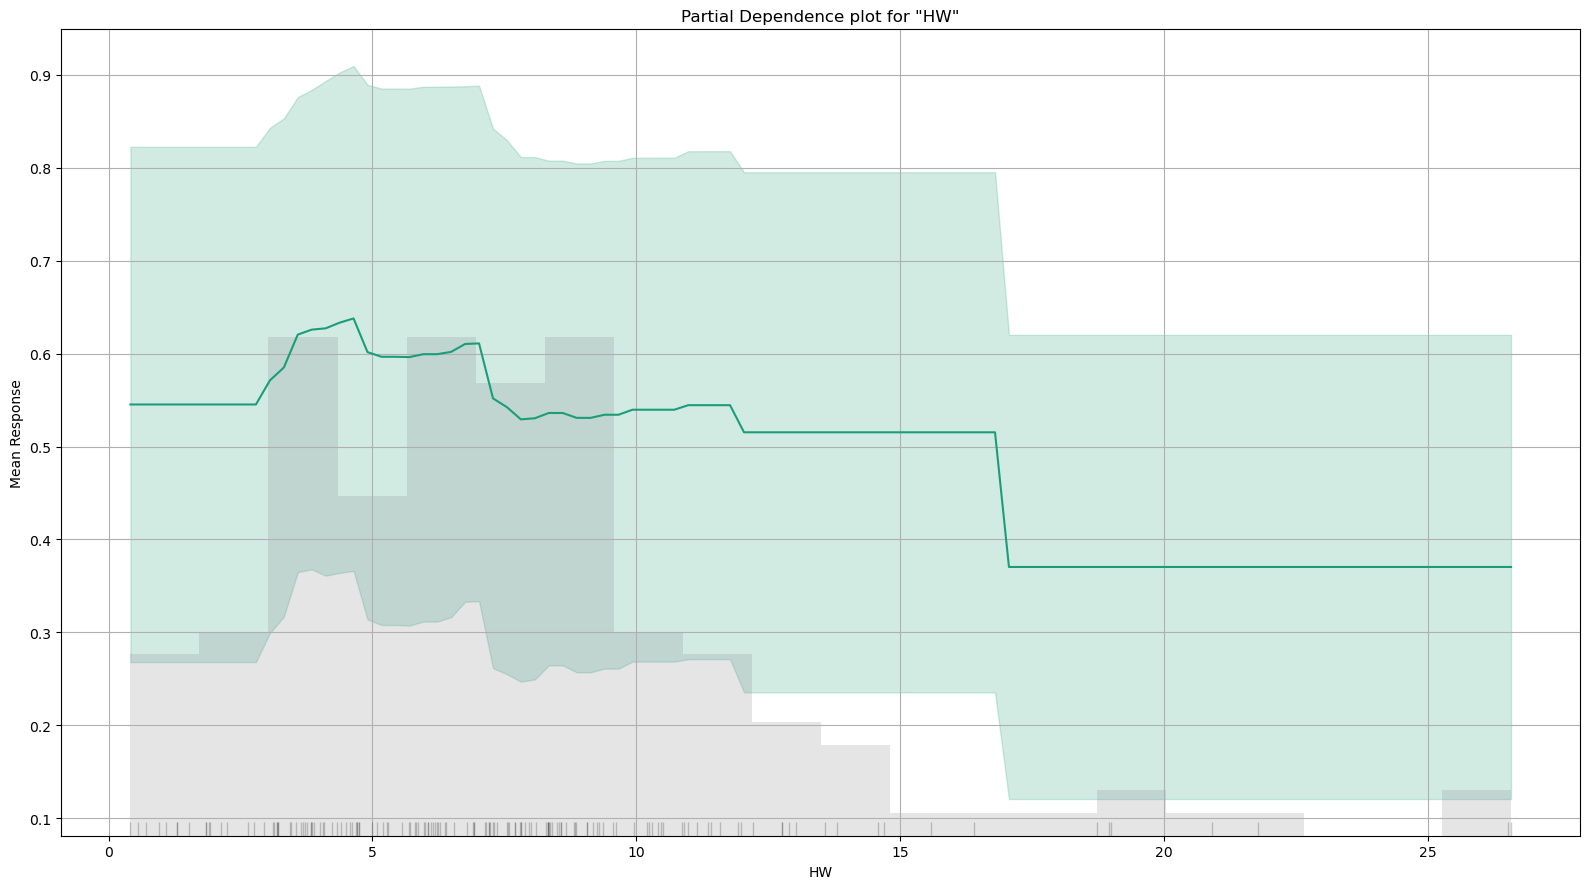

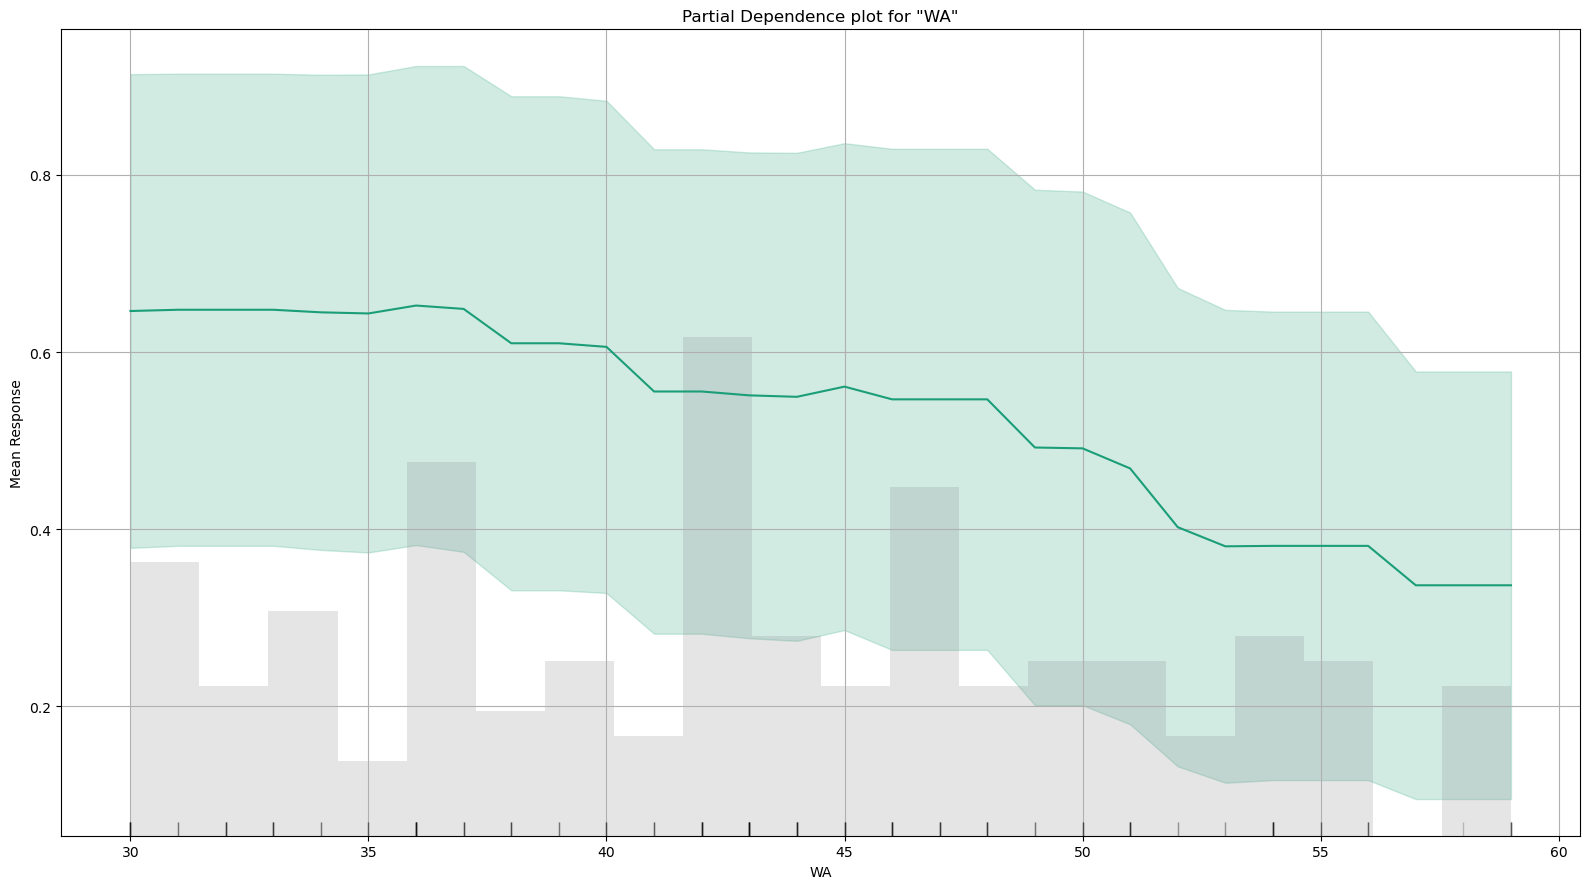

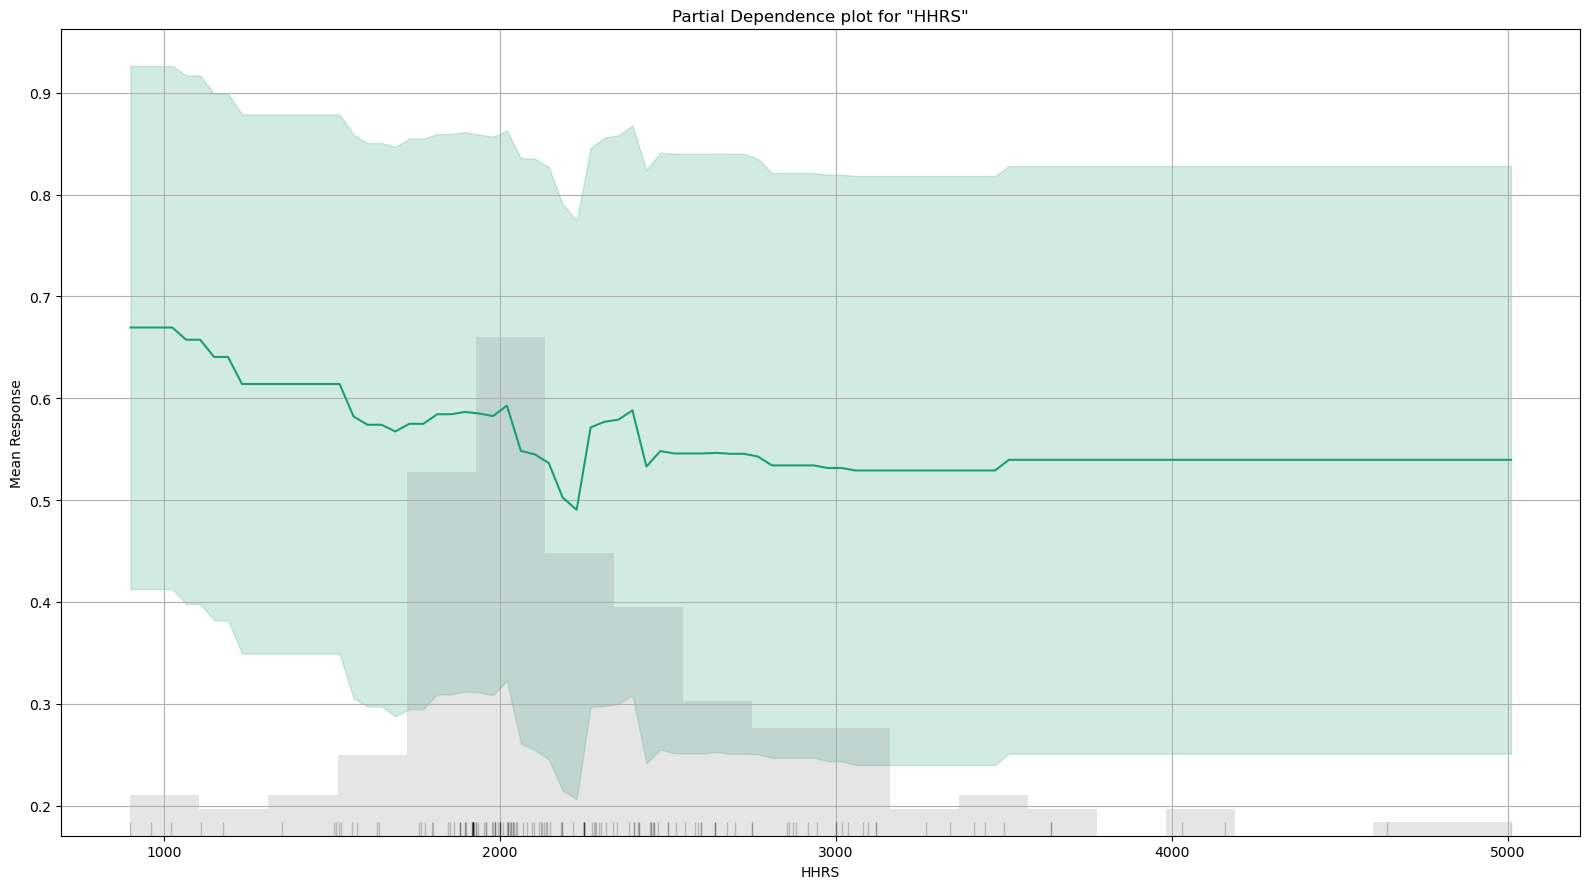

In [ ]:
%matplotlib inline
plt.show();
gbm_default.explain(test)

In [ ]:
print(gbm_default)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1700323553182_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,13262.0,5.0,5.0,5.0,8.0,23.0,16.48




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.05511890024691459
RMSE: 0.23477414731378451
LogLoss: 0.23116843900010717
Mean Per-Class Error: 0.02835025736545893
AUC: 0.9956237857758016
AUCPR: 0.9969284660800918
Gini: 0.9912475715516031

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47541314711811655: 


,,0,1,Error,Rate
0,0,176.0,11.0,0.0588,(11.0/187.0)
1,1,2.0,265.0,0.0075,(2.0/267.0)
2,Total,178.0,276.0,0.0286,(13.0/454.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.475413,0.976059,238.0
1,max f2,0.475413,0.985863,238.0
2,max f0point5,0.564306,0.980168,225.0
3,max accuracy,0.550484,0.971366,227.0
4,max precision,0.979918,1.000000,0.0
5,max recall,0.336399,1.000000,272.0
6,max specificity,0.979918,1.000000,0.0
7,max absolute_mcc,0.475413,0.941267,238.0
8,max min_per_class_accuracy,0.550484,0.970037,227.0
9,max mean_per_class_accuracy,0.550484,0.971650,227.0



Gains/Lift Table: Avg response rate: 58.81 %, avg score: 58.78 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011013,0.966809,1.700375,1.700375,1.000000,0.972580,1.000000,0.972580,0.018727,0.018727,70.037453,70.037453
1,,2,0.022026,0.963672,1.700375,1.700375,1.000000,0.965437,1.000000,0.969009,0.018727,0.037453,70.037453,70.037453
2,,3,0.030837,0.958025,1.700375,1.700375,1.000000,0.960530,1.000000,0.966586,0.014981,0.052434,70.037453,70.037453
3,,4,0.041850,0.954412,1.700375,1.700375,1.000000,0.956141,1.000000,0.963838,0.018727,0.071161,70.037453,70.037453
4,,5,0.050661,0.950854,1.700375,1.700375,1.000000,0.952701,1.000000,0.961901,0.014981,0.086142,70.037453,70.037453
5,,6,0.101322,0.935087,1.700375,1.700375,1.000000,0.943061,1.000000,0.952481,0.086142,0.172285,70.037453,70.037453
6,,7,0.149780,0.917912,1.700375,1.700375,1.000000,0.925867,1.000000,0.943871,0.082397,0.254682,70.037453,70.037453
7,,8,0.200441,0.906550,1.700375,1.700375,1.000000,0.911011,1.000000,0.935565,0.086142,0.340824,70.037453,70.037453
8,,9,0.299559,0.863399,1.700375,1.700375,1.000000,0.885799,1.000000,0.919098,0.168539,0.509363,70.037453,70.037453
9,,10,0.400881,0.815737,1.700375,1.700375,1.000000,0.839567,1.000000,0.898997,0.172285,0.681648,70.037453,70.037453




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.2062720828492887
RMSE: 0.45417186488078354
LogLoss: 0.6149450741370872
Mean Per-Class Error: 0.2999237804878049
AUC: 0.7408536585365854
AUCPR: 0.7596663824518771
Gini: 0.4817073170731707

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43563916080892323: 


,,0,1,Error,Rate
0,0,31.0,33.0,0.5156,(33.0/64.0)
1,1,8.0,74.0,0.0976,(8.0/82.0)
2,Total,39.0,107.0,0.2808,(41.0/146.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.435639,0.783069,106.0
1,max f2,0.207683,0.882353,130.0
2,max f0point5,0.715884,0.737705,70.0
3,max accuracy,0.435639,0.719178,106.0
4,max precision,0.962731,1.000000,0.0
5,max recall,0.103141,1.000000,141.0
6,max specificity,0.962731,1.000000,0.0
7,max absolute_mcc,0.435639,0.433785,106.0
8,max min_per_class_accuracy,0.688657,0.687500,76.0
9,max mean_per_class_accuracy,0.634691,0.700076,82.0



Gains/Lift Table: Avg response rate: 56.16 %, avg score: 62.39 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.013699,0.961210,1.780488,1.780488,1.000000,0.962336,1.000000,0.962336,0.024390,0.024390,78.048780,78.048780
1,,2,0.020548,0.954104,1.780488,1.780488,1.000000,0.960317,1.000000,0.961663,0.012195,0.036585,78.048780,78.048780
2,,3,0.034247,0.945456,1.780488,1.780488,1.000000,0.949473,1.000000,0.956787,0.024390,0.060976,78.048780,78.048780
3,,4,0.041096,0.942921,1.780488,1.780488,1.000000,0.945315,1.000000,0.954875,0.012195,0.073171,78.048780,78.048780
4,,5,0.054795,0.940191,0.890244,1.557927,0.500000,0.941407,0.875000,0.951508,0.012195,0.085366,-10.975610,55.792683
5,,6,0.102740,0.922373,1.271777,1.424390,0.714286,0.931559,0.800000,0.942198,0.060976,0.146341,27.177700,42.439024
6,,7,0.150685,0.910159,1.271777,1.375831,0.714286,0.917460,0.772727,0.934327,0.060976,0.207317,27.177700,37.583149
7,,8,0.205479,0.888771,1.112805,1.305691,0.625000,0.899524,0.733333,0.925046,0.060976,0.268293,11.280488,30.569106
8,,9,0.301370,0.832581,1.398955,1.335366,0.785714,0.862409,0.750000,0.905116,0.134146,0.402439,39.895470,33.536585
9,,10,0.404110,0.782149,1.305691,1.327821,0.733333,0.805415,0.745763,0.879769,0.134146,0.536585,30.569106,32.782141




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2023-11-18 11:06:17,0.028 sec,0.0,0.492176,0.677541,0.500000,0.588106,1.000000,0.411894,0.496891,0.686965,0.500000,0.561644,1.000000,0.438356
1,,2023-11-18 11:06:17,0.229 sec,1.0,0.474380,0.642207,0.840634,0.858363,1.571232,0.240088,0.489271,0.671559,0.648723,0.670845,1.335366,0.328767
2,,2023-11-18 11:06:17,0.274 sec,2.0,0.459542,0.613702,0.858159,0.868625,1.573481,0.207048,0.482765,0.658531,0.701791,0.716579,1.375831,0.321918
3,,2023-11-18 11:06:17,0.309 sec,3.0,0.446551,0.589226,0.861794,0.870097,1.573481,0.191630,0.478135,0.649242,0.697027,0.714014,1.375831,0.349315
4,,2023-11-18 11:06:17,0.341 sec,4.0,0.434003,0.565791,0.887350,0.909676,1.700375,0.174009,0.474000,0.641119,0.704268,0.700244,0.445122,0.335616
5,,2023-11-18 11:06:17,0.377 sec,5.0,0.423858,0.546920,0.892277,0.914933,1.700375,0.169604,0.470729,0.634589,0.704459,0.696442,0.890244,0.308219
6,,2023-11-18 11:06:18,0.397 sec,6.0,0.413733,0.528092,0.903874,0.925295,1.700375,0.165198,0.468315,0.629986,0.715130,0.693235,0.890244,0.287671
7,,2023-11-18 11:06:18,0.407 sec,7.0,0.404947,0.511753,0.909481,0.931621,1.700375,0.156388,0.465165,0.624042,0.717035,0.696910,0.890244,0.273973
8,,2023-11-18 11:06:18,0.443 sec,8.0,0.396748,0.496660,0.918024,0.939953,1.700375,0.154185,0.463517,0.620515,0.728087,0.737761,1.780488,0.267123
9,,2023-11-18 11:06:18,0.456 sec,9.0,0.389513,0.483126,0.923642,0.944347,1.700375,0.154185,0.462565,0.619151,0.724943,0.729650,1.780488,0.287671



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,AX,131.398773,1.000000,0.302506
1,K618,45.558479,0.346719,0.104885
2,HW,40.407906,0.307521,0.093027
3,WA,37.447762,0.284993,0.086212
4,HHRS,37.132977,0.282598,0.085487
5,WE,31.556528,0.240158,0.072649
6,HA,27.677494,0.210637,0.063719
7,KL6,25.989029,0.197787,0.059832
8,UN,15.818825,0.120388,0.036418
9,WMED,14.153994,0.107718,0.032585


In [ ]:
test_perf_default = gbm_default.model_performance(test)

In [ ]:
print("Default: ",test_perf_default.auc())

0.786520697913103


Hyper-Parameter Search
Next, we'll do real hyper-parameter optimization to see if we can beat the best AUC so far (around 94%).

The key here is to start tuning some key parameters first (i.e., those that we expect to have the biggest impact on the results). From experience with gradient boosted trees across many datasets, we can state the following "rules":

- Build as many trees (`ntrees`) as it takes until the validation set error starts increasing.
- A lower learning rate (learn_rate) is generally better, but will require more trees. Using learn_rate=0.02and learn_rate_annealing=0.995 (reduction of learning rate with each additional tree) can help speed up convergence without sacrificing accuracy too much, and is great to hyper-parameter searches. For faster scans, use values of 0.05 and 0.99 instead.
- The optimum maximum allowed depth for the trees (max_depth) is data dependent, deeper trees take longer to train, especially at depths greater than 10.
- Row and column sampling (sample_rate and col_sample_rate) can improve generalization and lead to lower validation and test set errors. Good general values for large datasets are around 0.7 to 0.8 (sampling 70-80 percent of the data) for both parameters. Column sampling per tree (col_sample_rate_per_tree) can also be tuned. Note that it is multiplicative with col_sample_rate, so setting both parameters to 0.8 results in 64% of columns being considered at any given node to split.
- For highly imbalanced classification datasets (e.g., fewer buyers than non-buyers), stratified row sampling based on response class membership can help improve predictive accuracy. It is configured with sample_rate_per_class (array of ratios, one per response class in lexicographic order).
- Most other options only have a small impact on the model performance, but are worth tuning with a Random hyper-parameter search nonetheless, if highest performance is critical.

First we want to know what value of `max_depth` to use because it has a big impact on the model training time and optimal values depend strongly on the dataset. We'll do a quick Cartesian grid search to get a rough idea of good candidate `max_depth` values. Each model in the grid search will use early stopping to tune the number of trees using the validation set AUC, as before. We'll use learning rate annealing to speed up convergence without sacrificing too much accuracy.

Source: https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/gbm/gbmTuning.ipynb

In [ ]:
hyper_params = {'max_depth':list(range(1, 30, 2))} 

gbm_base = H2OGradientBoostingEstimator(
    ntrees = 400,
    learn_rate = 0.05,
    learn_rate_annealing = 0.99,
    sample_rate = 0.8,
    col_sample_rate = .8,
    seed = 1234,
    stopping_rounds = 5,
    stopping_metric = "AUC",
    stopping_tolerance = 1e-4
)
grid_for_gbm_base = H2OGridSearch(
    gbm_base ,
    hyper_params,
    grid_id  = 'grid_id',
    search_criteria = {'strategy': "Cartesian"}
)

- `learn_rate_annealing`:Specifies to reduce the `learn_rate` by this factor after every tree. So for `N` trees, GBM starts with `learn_rate` and ends with `learn_rate`$^N$

- `histogram_type`. To find the split point the numerical feature is binned into range [0, 5), [5, 10)... So split point should searched in each range in parallel. `AUTO` has as step = (Min-Max)/N, where `N` is number of bins (`nbins`) .  `UniformAdaptive` each step has the same size. `QuantilesGlobal` compute the bins based in quantiles, the steps is used on all levels of tree.   

- `nbins`: The `nbins` option specifies the number of bins to be included in the histogram and then split at the best point. These split points are evaluated at the boundaries of each of these bins. 

Note: increasing `nbins` can have a dramatic effect on the amount of `overfitting`

In [ ]:
grid_for_gbm_base.train(
    x = numerical_feats + categorical_feats,
    y = response,
    training_frame = train,
    validation_frame = valid
)

gbm Grid Build progress: |

████████████████████████████████████████████████| 100%


In [ ]:
grid_result_for_gbm_base = grid_for_gbm_base.get_grid(sort_by='auc', decreasing=True)

print(grid_result_for_gbm_base)

     max_depth         model_ids                 auc
0            5   grid_id_model_3  0.7465701219512195
1            3   grid_id_model_2  0.7267530487804879
2            7   grid_id_model_4  0.7259908536585366
3           19  grid_id_model_10  0.7227515243902439
4           21  grid_id_model_11  0.7227515243902439
5           23  grid_id_model_12  0.7227515243902439
6           25  grid_id_model_13  0.7227515243902439
7           27  grid_id_model_14  0.7227515243902439
8           29  grid_id_model_15  0.7227515243902439
9           11   grid_id_model_6  0.7227515243902439
10          13   grid_id_model_7  0.7227515243902439
11          15   grid_id_model_8  0.7227515243902439
12          17   grid_id_model_9  0.7227515243902439
13           9   grid_id_model_5  0.7221798780487805
14           1   grid_id_model_1  0.6997903963414634



In [ ]:
table_metrics = grid_result_for_gbm_base.sorted_metric_table()
table_metrics.max_depth = table_metrics.max_depth.astype('int32')

In [ ]:
max_depths = table_metrics["max_depth"][0:5]

In [ ]:
new_max = int(max_depths.max())
new_min = int(max_depths.min())

In [ ]:
hyper_params_tune = {
    'max_depth':list(range(new_min, new_max + 1)),
    'sample_rate':[x/100 for x in range(50, 101)],
    'col_sample_rate':[x/100 for x in range(60, 101)],
    'min_rows':[x for x in range(2, int(math.log2(1_000)) + 1)],
    'nbins':[x for x in range(5, 30,5)],
    # split the node if squared error reduccion has as min this value.
    # If min_split_improvement is set to 1e-8, the split will not occur if the 
    # squared error reduction is less than 1e-8
    'min_split_improvement':[0, 1e-8, 1e-6, 1e-4],
    'histogram_type':["UniformAdaptive", "QuantilesGlobal"]
}
search_criteria_tune = {
    'strategy':"RandomDiscrete",
    "max_runtime_secs":1800,
    "max_models":100,
    "seed":1234,
    # if stopping_metric doesn't change for 5 consecutive scoring events, then 
    # the training process will stop early.
    "stopping_rounds":5,
    "stopping_metric":"AUC",
    "stopping_tolerance":1e-3
}

In [ ]:
gbm_base = H2OGradientBoostingEstimator(
    ntrees = 400,
    learn_rate = 0.02,
    learn_rate_annealing = 0.99,
    seed = 1234,
    stopping_rounds = 5,
    stopping_metric = "AUC",
    stopping_tolerance = 1e-4)

grid_for_gbm_base = H2OGridSearch(
    gbm_base, 
    hyper_params = hyper_params_tune,
    grid_id = 'final_grid',
    search_criteria = search_criteria_tune,
)

grid_for_gbm_base.train(
    x = numerical_feats + categorical_feats,
    y = response,
    training_frame = train,
    validation_frame = valid,
    max_runtime_secs = 1800
)

In [ ]:
grid_result_gbm_base = grid_for_gbm_base.get_grid(sort_by='auc', decreasing=True)
best_model = h2o.get_model(grid_result_gbm_base.sorted_metric_table()['model_ids'][0])

In [ ]:
performance_best_model = best_model.model_performance(test)

In [ ]:
performance_best_model.auc()

0.7942182689018132

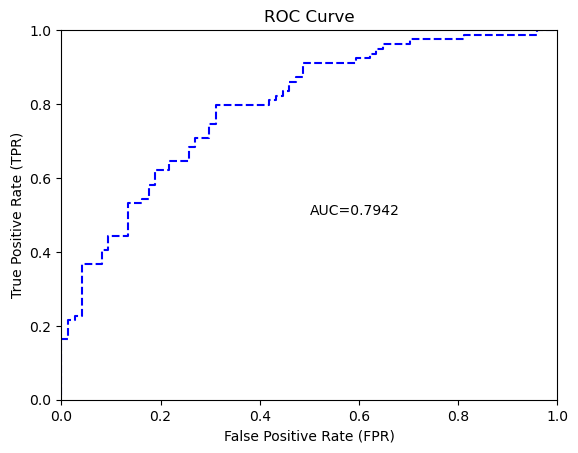

In [ ]:
performance_best_model.plot()

In [ ]:
performance_best_model.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5473951309730151: 


,,0,1,Error,Rate
0,0,48.0,26.0,0.3514,(26.0/74.0)
1,1,12.0,67.0,0.1519,(12.0/79.0)
2,Total,60.0,93.0,0.2484,(38.0/153.0)
